In [2]:
import pandas as pd
df_as = pd.read_csv("As.csv")
df_as = df_as.rename(columns={df_as.columns[0]: "Year"})
for col in df_as.columns[1:]:
    df_as[col] = pd.to_numeric(df_as[col], errors="coerce")

print("Asia 年の最初と最後:", df_as["Year"].min(), df_as["Year"].max())
print("末尾15行:")
print(df_as.tail(15))

modern_cols = ["Coal", "Oil", "Gas", "Electricity", "Nuclear", "Biofuels"]
modern = df_as[modern_cols].sum(axis=1)
rate = modern / df_as["Total"]
print("Asia modern share の最大値:", rate.max())


Asia 年の最初と最後: 1820.0 2020.0
末尾15行:
       Year     Food  Fuelwood   Fodder  Coal  Oil      Gas  Electricity  \
187  2006.0  366.417   365.968  126.418   NaN  NaN  308.211      107.529   
188  2007.0  375.346   364.899  133.676   NaN  NaN  334.387      117.028   
189  2008.0  383.586   363.689  134.183   NaN  NaN  361.604      141.326   
190  2009.0  378.439   362.534  133.238   NaN  NaN  373.181      149.555   
191  2010.0  386.095   320.608  123.296   NaN  NaN  412.651      174.935   
192  2011.0  392.821   320.486  123.807   NaN  NaN  454.692      191.446   
193  2012.0  398.736   319.961  124.327   NaN  NaN  486.769      227.178   
194  2013.0  403.213   302.384  124.847   NaN  NaN  506.675      265.024   
195  2014.0  409.297   301.838  125.355   NaN  NaN  526.019      307.815   
196  2015.0  415.545   301.080  124.489   NaN  NaN  530.649      345.573   
197  2016.0  417.744   298.580  123.387   NaN  NaN  544.230      397.426   
198  2017.0  423.167   289.044  124.511   NaN  NaN  5

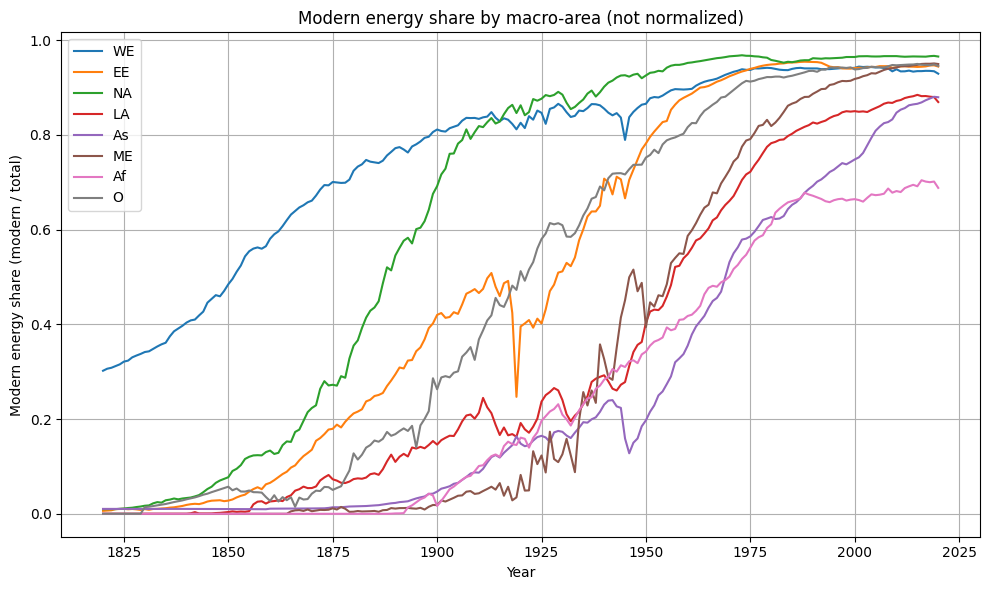

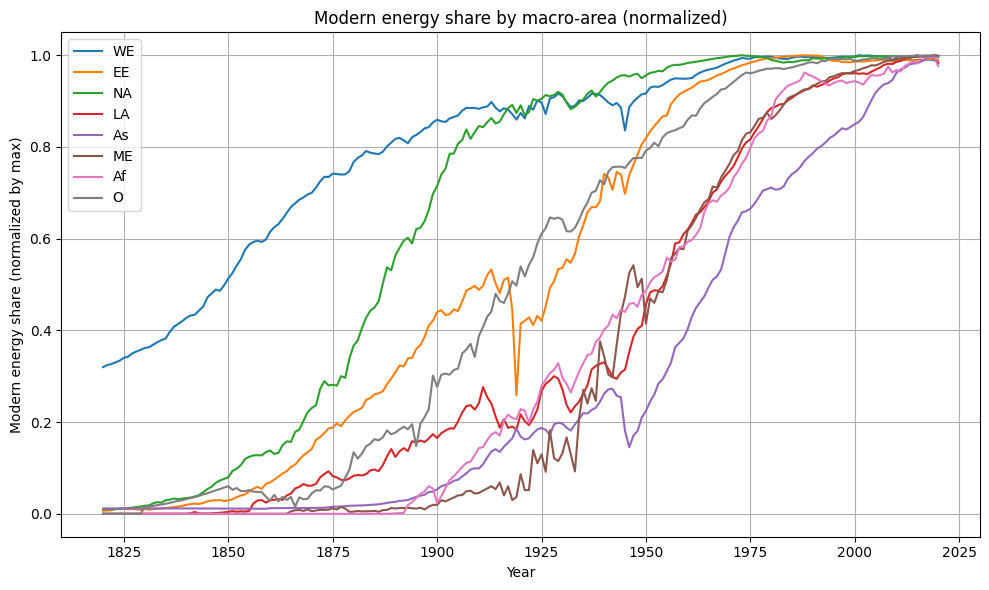

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 設定 ----------
region_files = {
    "WE": "WE.csv",
    "EE": "EE.csv",
    "NA": "NA.csv",
    "LA": "LA.csv",
    "As": "As.csv",
    "ME": "ME.csv",
    "Af": "Af.csv",
    "O":  "O.csv",
}

modern_cols = ["Coal", "Oil", "Gas", "Electricity", "Nuclear", "Biofuels"]

# 結果保存用
years_dict = {}
modern_rate = {}
modern_rate_norm = {}

# .npy の保存先
out_dir = "modern_rate_npy"
os.makedirs(out_dir, exist_ok=True)

# ---------- 計算 ----------
for region, csv_path in region_files.items():
    # カンマ付き数値をちゃんと読む
    df = pd.read_csv(csv_path, thousands=",")

    # 列名の前後の空白を削除
    df.columns = [str(c).strip() for c in df.columns]

    # 1列目を Year にリネーム（念のため）
    first_col = df.columns[0]
    if first_col != "Year":
        df = df.rename(columns={first_col: "Year"})

    # Year 以外を数値化（カンマ・空白を削除してから）
    for col in df.columns:
        if col != "Year":
            df[col] = (
                df[col]
                .astype(str)
                .str.replace(",", "", regex=False)  # 千の位のカンマを削除
                .str.strip()
                .replace({"": np.nan})
            )
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # modern_cols に無い列があれば 0 列として追加（地域によっては Nuclear 等が無い可能性）
    for col in modern_cols:
        if col not in df.columns:
            df[col] = 0.0

    # 完全に空の行を落とす
    df = df.dropna(how="all")

    # Year が NaN の行を落とす（安全のため）
    df = df.dropna(subset=["Year"])

    # Total が NaN の行も落とす（Total が定義されていない年は使わない）
    df = df.dropna(subset=["Total"])

    # --------- 計算部分 ---------
    years = df["Year"].to_numpy(dtype=int)
    years_dict[region] = years

    modern = df[modern_cols].sum(axis=1).to_numpy(dtype=float)
    total = df["Total"].to_numpy(dtype=float)

    rate = modern / total
    modern_rate[region] = rate

    max_val = np.nanmax(rate)
    rate_norm = rate / max_val if max_val > 0 else rate
    modern_rate_norm[region] = rate_norm

    # ---------- .npy で保存 ----------
    np.save(os.path.join(out_dir, f"years_{region}.npy"), years)
    np.save(os.path.join(out_dir, f"modern_rate_{region}.npy"), rate)
    np.save(os.path.join(out_dir, f"modern_rate_norm_{region}.npy"), rate_norm)

# ---------- グラフ（正規化前） ----------
plt.figure(figsize=(10, 6))
for region in region_files.keys():
    plt.plot(years_dict[region], modern_rate[region], label=region)

plt.xlabel("Year")
plt.ylabel("Modern energy share (modern / total)")
plt.title("Modern energy share by macro-area (not normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- グラフ（正規化後） ----------
plt.figure(figsize=(10, 6))
for region in region_files.keys():
    plt.plot(years_dict[region], modern_rate_norm[region], label=region)

plt.xlabel("Year")
plt.ylabel("Modern energy share (normalized by max)")
plt.title("Modern energy share by macro-area (normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
import numpy as np
modern_rate_As = np.load("modern_rate_npy/modern_rate_As.npy")

print((modern_rate_As))

[0.01032428 0.01033563 0.01035178 0.01036277 0.01037359 0.01038915
 0.01039961 0.01041473 0.01042479 0.01043953 0.01045407 0.01043978
 0.01042543 0.01041107 0.01039671 0.01038229 0.01036791 0.01035348
 0.01033909 0.01032464 0.01031015 0.01029575 0.01027664 0.01025751
 0.01024308 0.01022399 0.01020493 0.01019048 0.01017146 0.01015242
 0.01013796 0.01008228 0.01003096 0.00997487 0.00992311 0.0098666
 0.00981444 0.00975751 0.00970494 0.00964759 0.01079065 0.01081902
 0.01085202 0.01088508 0.01092749 0.0109699  0.01101706 0.01107368
 0.0111442  0.01121964 0.01128128 0.01138373 0.0114894  0.01158895
 0.01240797 0.01375618 0.01382298 0.01378639 0.0145851  0.01537797
 0.01563801 0.01591071 0.01617167 0.01641668 0.01713213 0.0176614
 0.01823089 0.01954271 0.02064709 0.0221787  0.02296813 0.0246567
 0.02541993 0.02642237 0.02958723 0.03245487 0.03474226 0.03654339
 0.04193636 0.04251839 0.04694288 0.05301519 0.05533601 0.05815023
 0.063337   0.06531299 0.07168312 0.07769673 0.08492582 0.0874992

In [5]:
import numpy as np
import pandas as pd

regions = ["WE","EE","NA","LA","As","ME","Af","O"]
target_years = [1850, 1950, 2000]

rows = []

for r in regions:
    years       = np.load(f"modern_rate_npy/years_{r}.npy")
    modern      = np.load(f"modern_rate_npy/modern_rate_{r}.npy")
    modern_norm = np.load(f"modern_rate_npy/modern_rate_norm_{r}.npy")

    for y in target_years:
        # 年に対応するインデックスを取得（int/floatの差があっても動くように）
        idx = np.where(years == y)[0]
        if len(idx) == 0:
            idx = np.where(np.isclose(years, y))[0]
        if len(idx) == 0:
            print(f"Warning: year {y} not found for region {r}")
            continue

        i = idx[0]
        rows.append({
            "region": r,
            "year": int(years[i]),
            "modern_rate": float(modern[i]),
            "modern_rate_norm": float(modern_norm[i]),
        })

# DataFrame にまとめて確認
df = pd.DataFrame(rows)
print(df)

# 必要なら CSV で保存
df.to_csv("modern_rate_1850_1950_2000_all_regions.csv", index=False)


   region  year  modern_rate  modern_rate_norm
0      WE  1850     0.484579          0.513258
1      WE  1950     0.865582          0.916809
2      WE  2000     0.941491          0.997211
3      EE  1850     0.027833          0.029162
4      EE  1950     0.781860          0.819210
5      EE  2000     0.941114          0.986073
6      NA  1850     0.077214          0.079763
7      NA  1950     0.925425          0.955985
8      NA  2000     0.964366          0.996213
9      LA  1850     0.003756          0.004246
10     LA  1950     0.403878          0.456656
11     LA  2000     0.850000          0.961078
12     As  1850     0.010138          0.011516
13     As  1950     0.197314          0.224126
14     As  2000     0.748096          0.849750
15     ME  1850     0.000000          0.000000
16     ME  1950     0.394251          0.414671
17     ME  2000     0.918040          0.965590
18     Af  1850     0.000000          0.000000
19     Af  1950     0.342456          0.486314
20     Af  20

In [6]:
import pandas as pd

region_map = {
    "WE": [
        "Austria","Belgium","Denmark","Finland","France","Germany","Greece","Ireland",
        "Italy","Netherlands","Norway","Portugal","Spain","Sweden","Switzerland","UK"
    ],
    "EE": [
        "Bulgaria","Czechoslovakia","Hungary","Poland","Romania","USSR","Yugoslavia"
    ],
    "LA": [
        "Argentina","Bolivia","Brazil","Chile","Colombia","Costa Rica","Cuba",
        "Dominican Republic","Ecuador","El Salvador","Guatemala","Haiti","Honduras",
        "Mexico","Nicaragua","Panama","Paraguay","Peru","Uruguay","Venezuela"
    ],
    "As": [
        "China","India","Indonesia","Japan","Malaysia","Philippines","Thailand"
    ],
    "ME": [
        "Iran","Iraq","Israel","Saudi Arabia","Syria","Turkey"
    ],
    "Af": [
        "Algeria","Congo DR","Egypt","Ethiopia Eritrea","Libya","Malawi","Morocco",
        "Nigeria","South Africa","Tunisia","Zambia","Zimbabwe"
    ],
    "NA": [
        "Canada","USA"
    ],
    "O": [
        "Australia","New Zealand"
    ]
}

# CSV 化用データフレーム作成
rows = []
for region, countries in region_map.items():
    for c in countries:
        rows.append({"Country": c, "Region": region})

df_map = pd.DataFrame(rows)
df_map.to_csv("country_region_map.csv", index=False)
df_map.head()


,Country,Region
0,Austria,WE
1,Belgium,WE
2,Denmark,WE
3,Finland,WE
4,France,WE


In [41]:
import numpy as np
import pandas as pd

regions = ["WE","EE","NA","LA","As","ME","Af","O"]
target_years = [1850, 1950, 2000]

rows = []

for r in regions:
    years = np.load(f"modern_rate_npy/years_{r}.npy")
    rate = np.load(f"modern_rate_npy/modern_rate_{r}.npy")
    rate_norm = np.load(f"modern_rate_npy/modern_rate_norm_{r}.npy")

    for y in target_years:
        # ---- 年度のインデックスを探す（float 年対策）----
        # 完全一致
        idx = np.where(years == y)[0]
        if len(idx) == 0:
            # isclose で再トライ（1850.0 とか 1949.9999 の誤差対策）
            idx = np.where(np.isclose(years, y))[0]

        if len(idx) == 0:
            # 無い場合は飛ばす
            continue

        i = idx[0]

        # ---- 行の追加 ----
        rows.append({
            "Region": r,
            "Year": y,
            "modern_rate": float(rate[i]),
            "modern_rate_norm": float(rate_norm[i])
        })

# ---- DataFrame 化 ----
region_rate = pd.DataFrame(rows)
region_rate



,Region,Year,modern_rate,modern_rate_norm
0,WE,1850,0.484579,0.513258
1,WE,1950,0.865582,0.916809
2,WE,2000,0.941491,0.997211
3,EE,1850,0.027833,0.029162
4,EE,1950,0.781860,0.819210
5,EE,2000,0.941114,0.986073
6,NA,1850,0.077214,0.079763
7,NA,1950,0.925425,0.955985
8,NA,2000,0.964366,0.996213
9,LA,1850,0.003756,0.004246


In [67]:
mapping = pd.read_csv("country_region_map.csv")

rows = []

for y in target_years:
    # 年ごとの地域データから、norm も含めて取り出す
    tmp_r = region_rate.loc[region_rate["Year"] == y,
                            ["Region", "modern_rate", "modern_rate_norm"]]

    # 国－地域マップと結合
    tmp_c = mapping.merge(tmp_r, on="Region", how="left")

    # 年を付与
    tmp_c["Year"] = y
    rows.append(tmp_c)

country_rate = pd.concat(rows, ignore_index=True)

# すでにある前提：
# region_rate: Region, Year, modern_rate, modern_rate_norm
# country_rate: Country, Region, modern_rate, modern_rate_norm, Year
# target_years: [1850,1950,2000] など

# 1) NA 地域の年ごとの値（raw / norm）を取り出す
na_raw = (
    region_rate[region_rate["Region"] == "NA"]
    .set_index("Year")["modern_rate"]
)
na_norm = (
    region_rate[region_rate["Region"] == "NA"]
    .set_index("Year")["modern_rate_norm"]
)

# 2) Canada と USA に NA の値を強制的にコピー
for cname in ["Canada", "USA"]:
    for y in target_years:
        raw_val = float(na_raw.loc[y])          # NA のその年の raw
        norm_val = float(na_norm.loc[y])        # NA のその年の norm

        mask = (country_rate["Country"] == cname) & (country_rate["Year"] == y)

        country_rate.loc[mask, "Region"] = "NA"
        country_rate.loc[mask, "modern_rate"] = raw_val
        country_rate.loc[mask, "modern_rate_norm"] = norm_val

# 確認
print(country_rate[country_rate["Country"] == "Canada"])
print(country_rate[country_rate["Country"] == "USA"])
#country_rateを上書き
country_rate.to_csv("country_rate.csv", index=False)





    Country Region  modern_rate  modern_rate_norm  Year
68   Canada     NA     0.077214          0.079763  1850
140  Canada     NA     0.925425          0.955985  1950
212  Canada     NA     0.964366          0.996213  2000
    Country Region  modern_rate  modern_rate_norm  Year
69      USA     NA     0.077214          0.079763  1850
141     USA     NA     0.925425          0.955985  1950
213     USA     NA     0.964366          0.996213  2000


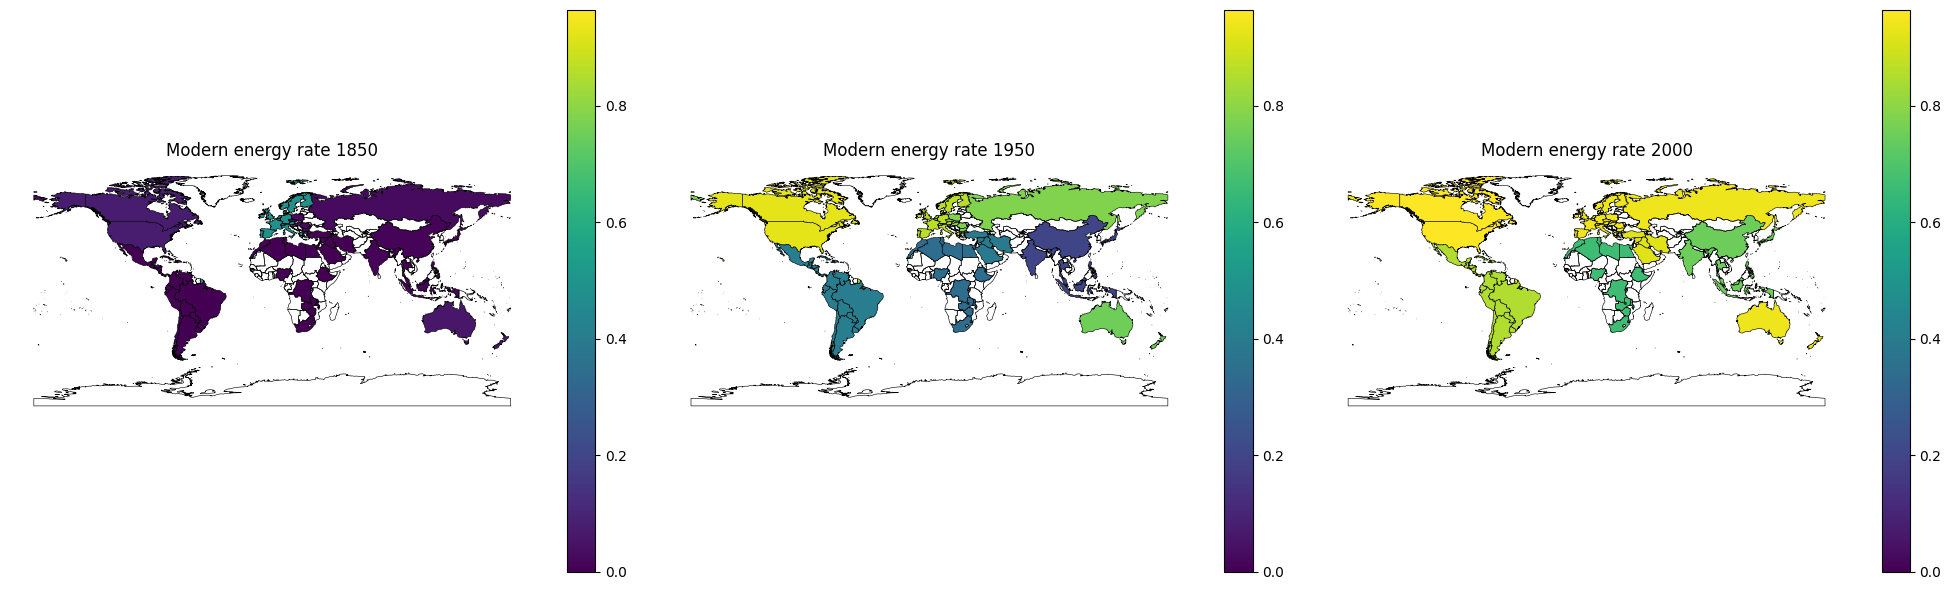

In [66]:
import geopandas as gpd
import matplotlib.pyplot as plt
import unicodedata

# =========================
# 1. 国名のクリーニング
# =========================
def clean_name(s):
    if not isinstance(s, str):
        return s
    s = unicodedata.normalize("NFKD", s)              # 上付き文字など分解
    s = "".join(c for c in s if c.isalpha() or c in [" ", "."])
    return s.strip()

country_rate_plot = country_rate.copy()
country_rate_plot["Country"] = country_rate_plot["Country"].apply(clean_name)

# Natural Earth 側の国名に合わせる
rename_dict = {
    "Congo DR": "Democratic Republic of the Congo",
    "Czechoslovakia": "Czechia",
    "Ethiopia Eritrea": "Ethiopia",
    "UK": "United Kingdom",
    "USA": "United States of America",
    "USSR": "Russia",
    "Yugoslavia": "Serbia",
}
country_rate_plot["Country"] = country_rate_plot["Country"].replace(rename_dict)

# =========================
# 2. 世界地図データ読込み
# =========================
url = (
    "https://naturalearth.s3.amazonaws.com/50m_cultural/"
    "ne_50m_admin_0_countries.zip"
)
world = gpd.read_file(url)
world = world.rename(columns={"ADMIN": "Country"})

# （確認したければ）
# world_names = set(world["Country"])
# print(sorted(set(country_rate_plot["Country"]) - world_names))

# カラーバー共通スケール
vmin = country_rate_plot["modern_rate"].min()
vmax = country_rate_plot["modern_rate"].max()

# =========================
# 3. 1850 / 1950 / 2000 を描画
# =========================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, y in zip(axes, target_years):
    # 下地：全世界の国境線（全部表示）
    world.plot(
        ax=ax,
        facecolor="none",
        edgecolor="lightgrey",
        linewidth=0.3,
    )

    # 対象年の 72カ国の値をマージ
    df_y = country_rate_plot[country_rate_plot["Year"] == y]
    gdf_y = world.merge(df_y, on="Country", how="left")

    # modern_rate がある国だけ塗る
    gdf_y.plot(
        column="modern_rate",
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
        linewidth=0.4,
        edgecolor="black",
        legend=True,
        ax=ax,
        missing_kwds={"color": "none"},  # 値なし国は塗らない
    )

    ax.set_title(f"Modern energy rate {y}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()


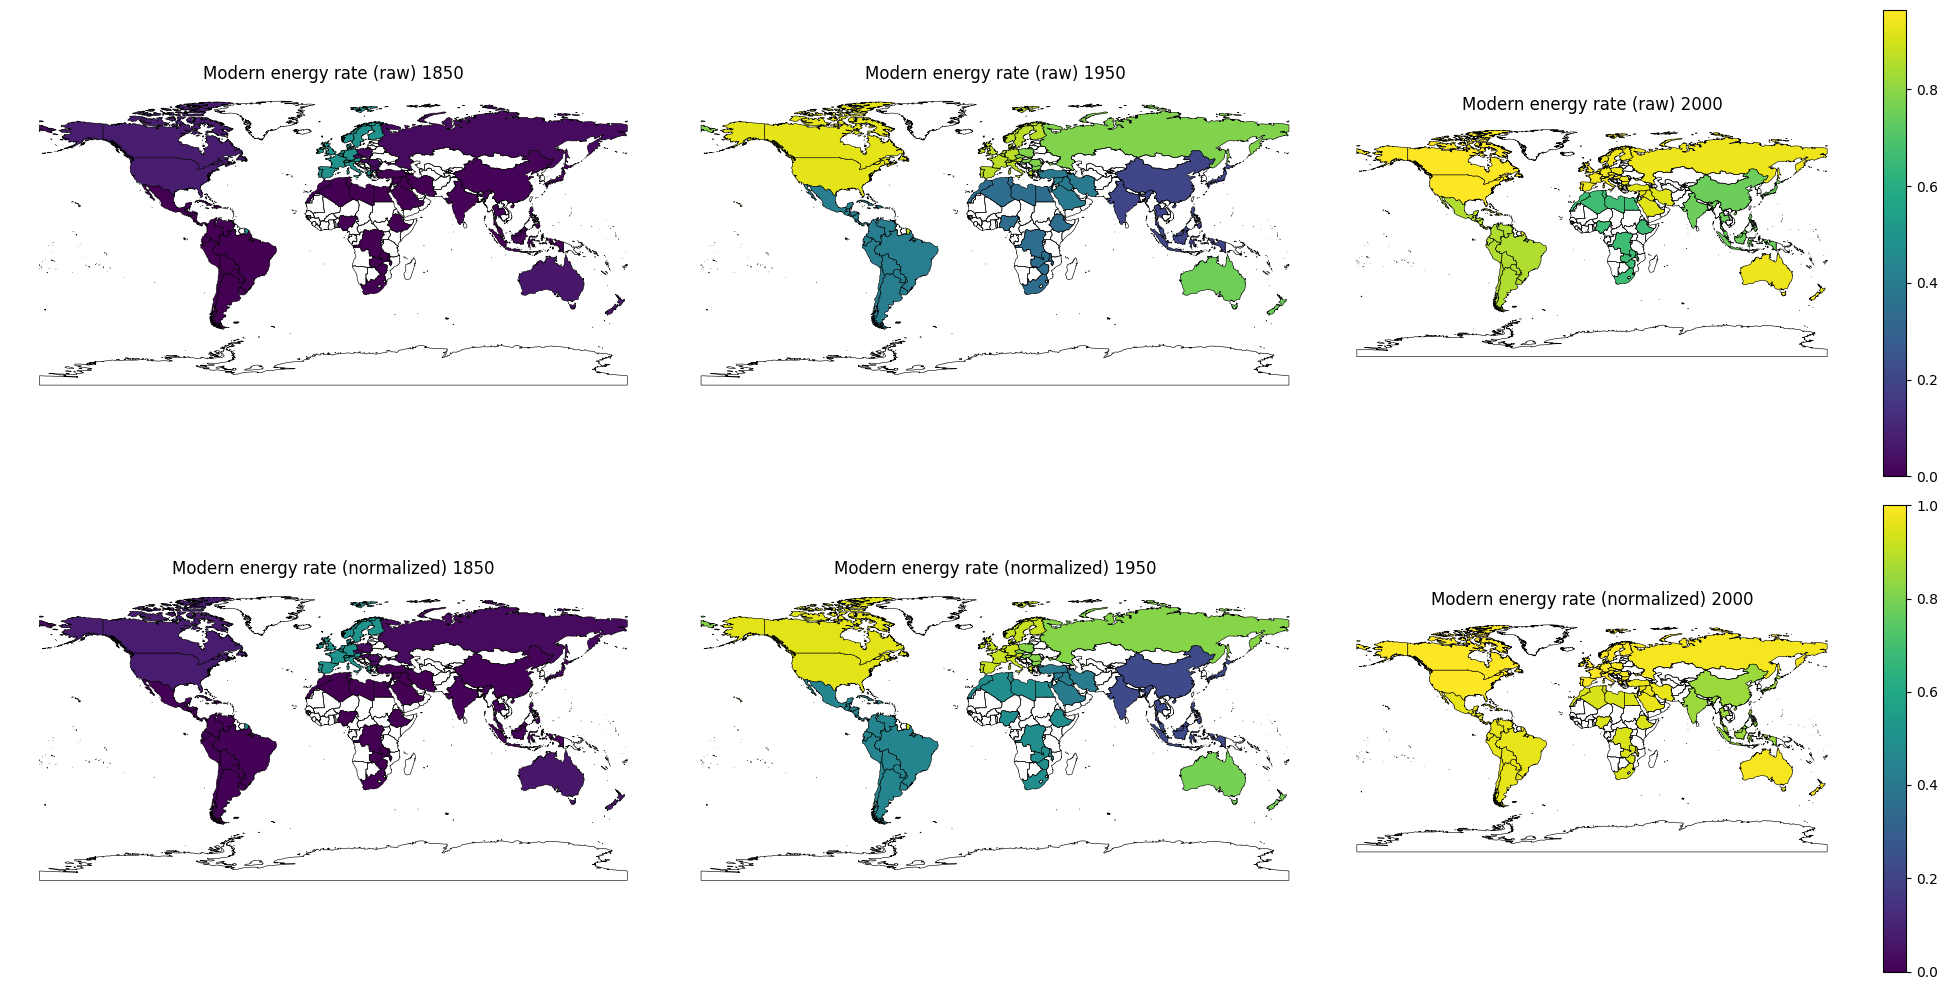

In [65]:
import geopandas as gpd
import matplotlib.pyplot as plt
import unicodedata

# =========================
# 1. 国名のクリーニング
# =========================
def clean_name(s):
    if not isinstance(s, str):
        return s
    s = unicodedata.normalize("NFKD", s)              # 上付き文字など分解
    s = "".join(c for c in s if c.isalpha() or c in [" ", "."])
    return s.strip()

country_rate_plot = country_rate.copy()
country_rate_plot["Country"] = country_rate_plot["Country"].apply(clean_name)

# Natural Earth 側の国名に合わせる
rename_dict = {
    "Congo DR": "Democratic Republic of the Congo",
    "Czechoslovakia": "Czechia",
    "Ethiopia Eritrea": "Ethiopia",
    "UK": "United Kingdom",
    "USA": "United States of America",
    "USSR": "Russia",
    "Yugoslavia": "Serbia",
}
country_rate_plot["Country"] = country_rate_plot["Country"].replace(rename_dict)

# =========================
# 2. 世界地図データ読込み
# =========================
url = (
    "https://naturalearth.s3.amazonaws.com/50m_cultural/"
    "ne_50m_admin_0_countries.zip"
)
world = gpd.read_file(url)
world = world.rename(columns={"ADMIN": "Country"})

# カラーバー共通スケール
vmin_raw  = country_rate_plot["modern_rate"].min()
vmax_raw  = country_rate_plot["modern_rate"].max()
vmin_norm = 0.0
vmax_norm = 1.0

# =========================
# 3. 1850 / 1950 / 2000 を描画（上段：raw，下段：norm）
# =========================
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for col, y in enumerate(target_years):
    # ----- 上段：元の modern_rate -----
    ax = axes[0, col]

    # 国境線だけ描画
    world.plot(
        ax=ax,
        facecolor="none",
        edgecolor="lightgrey",
        linewidth=0.3,
    )

    df_y = country_rate_plot[country_rate_plot["Year"] == y]
    gdf_y = world.merge(df_y, on="Country", how="left")

    gdf_y.plot(
        column="modern_rate",
        cmap="viridis",
        vmin=vmin_raw,
        vmax=vmax_raw,
        linewidth=0.4,
        edgecolor="black",
        legend=(col == 2),        # カラーバーは右端だけ
        ax=ax,
        missing_kwds={"color": "none"},
    )

    ax.set_title(f"Modern energy rate (raw) {y}")
    ax.set_axis_off()

    # ----- 下段：正規化 modern_rate_norm -----
    ax2 = axes[1, col]

    world.plot(
        ax=ax2,
        facecolor="none",
        edgecolor="lightgrey",
        linewidth=0.3,
    )

    gdf_y.plot(
        column="modern_rate_norm",
        cmap="viridis",
        vmin=vmin_norm,
        vmax=vmax_norm,
        linewidth=0.4,
        edgecolor="black",
        legend=(col == 2),        # カラーバーは右端だけ
        ax=ax2,
        missing_kwds={"color": "none"},
    )

    ax2.set_title(f"Modern energy rate (normalized) {y}")
    ax2.set_axis_off()

plt.tight_layout()
plt.show()


In [10]:
print(country_rate["Country"].unique())


['Austria' 'Belgium' 'Denmark' 'Finland' 'France' 'Germany' 'Greece'
 'Ireland' 'Italy' 'Netherlands' 'Norway' 'Portugal' 'Spain' 'Sweden'
 'Switzerland' 'UK' 'Bulgaria' 'Czechoslovakia' 'Hungary' 'Poland'
 'Romania' 'USSR' 'Yugoslavia' 'Argentina' 'Bolivia' 'Brazil' 'Chile'
 'Colombia' 'Costa Rica' 'Cuba' 'Dominican Republic' 'Ecuador'
 'El Salvador' 'Guatemala' 'Haiti' 'Honduras' 'Mexico' 'Nicaragua'
 'Panama' 'Paraguay' 'Peru' 'Uruguay' 'Venezuela' 'China' 'India'
 'Indonesia' 'Japan' 'Malaysia' 'Philippines' 'Thailand' 'Iran' 'Iraq'
 'Israel' 'Saudi Arabia' 'Syria' 'Turkey' 'Algeria' 'Congo DR' 'Egypt'
 'Ethiopia Eritrea' 'Libya' 'Malawi' 'Morocco' 'Nigeria' 'South Africa'
 'Tunisia' 'Zambia' 'Zimbabwe' 'Canada' 'USA' 'Australia' 'New Zealand']
